## Part 2

### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The measure of success would be the ratio of drivers crossing the bridge from both cities because this measures the connectivity between the two cities as opposed to just drivers who cross once and spend the rest of the day/night in one city vs the other. 

### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

There are a number of ways to test the efficacy of a toll reimbursement. (1) Only reimburse the tolls on odd days and compare the number of crossers on odd versus even days. Caveat here is that there might be a day effect but this should be negated if the experiment is carried out for more than 2 weeks (2) compare data collected prior to and after the toll reimbursement has been put into effect. As long as nothing else has changed, the number of crossers should increase, if the toll reimbursement is beneficial 

a. how you will implement the experiment

Recommend that the toll reimbursement is setup in a systematic way (control versus treatment) so that the effectiveness can be tested. 

b. what statistical test(s) you will conduct to verify the significance of the observation

A general linear model should be adequate to test the effect of the toll reimbursement. The basic model would be:
Number of crossers ~ Treatment (toll vs no toll) + Time of Day + Direction
Additional covariates can  be added based on EDA

c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.
If we do see a surge in crossers based in the toll reimbursement treatment, then it would make sense for the city operations to reimburse the toll. However, if we do not see a difference then the toll may not be an adequate motivator and the city operations to think about other incentives. Caveats would depend on the experimental design as stated above.  


## Part 3

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df= pd.DataFrame(data)

## 1.) Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [3]:
#convert dates to datetime format
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)

In [4]:
df['activity_period']= (df['last_trip_date'].subtract(df['signup_date'])).dt.days 
print("The maximum number of active days are: {} days".format(max(df['activity_period'])))

The maximum number of active days are: 181 days


#### looks like data was collected for approximately 6 months (~180 days). If users are classified as being "active" in the preceeding 30 days, that means they should have taken their last trip atleast 150 days since they signed up (in the last 30 days). We can classify users are active (1) or inactive (0) based on this criteria     

In [5]:
from __future__ import division
num_active = df['activity_period'][df['activity_period']>150].count()
total = df['activity_period'].count()
prop_active = num_active/total
print("The percent of retained users are: {}%".format(prop_active*100))

The percent of retained users are: 24.396%


In [6]:
# create a column for actively retained users "active" vs "not active"
df['active'] = 'active'
df['active'][df['activity_period']<150] ='not_active'

/Users/taniajogesh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


## EDA

#### compare mean feature values for users that are active and not active 

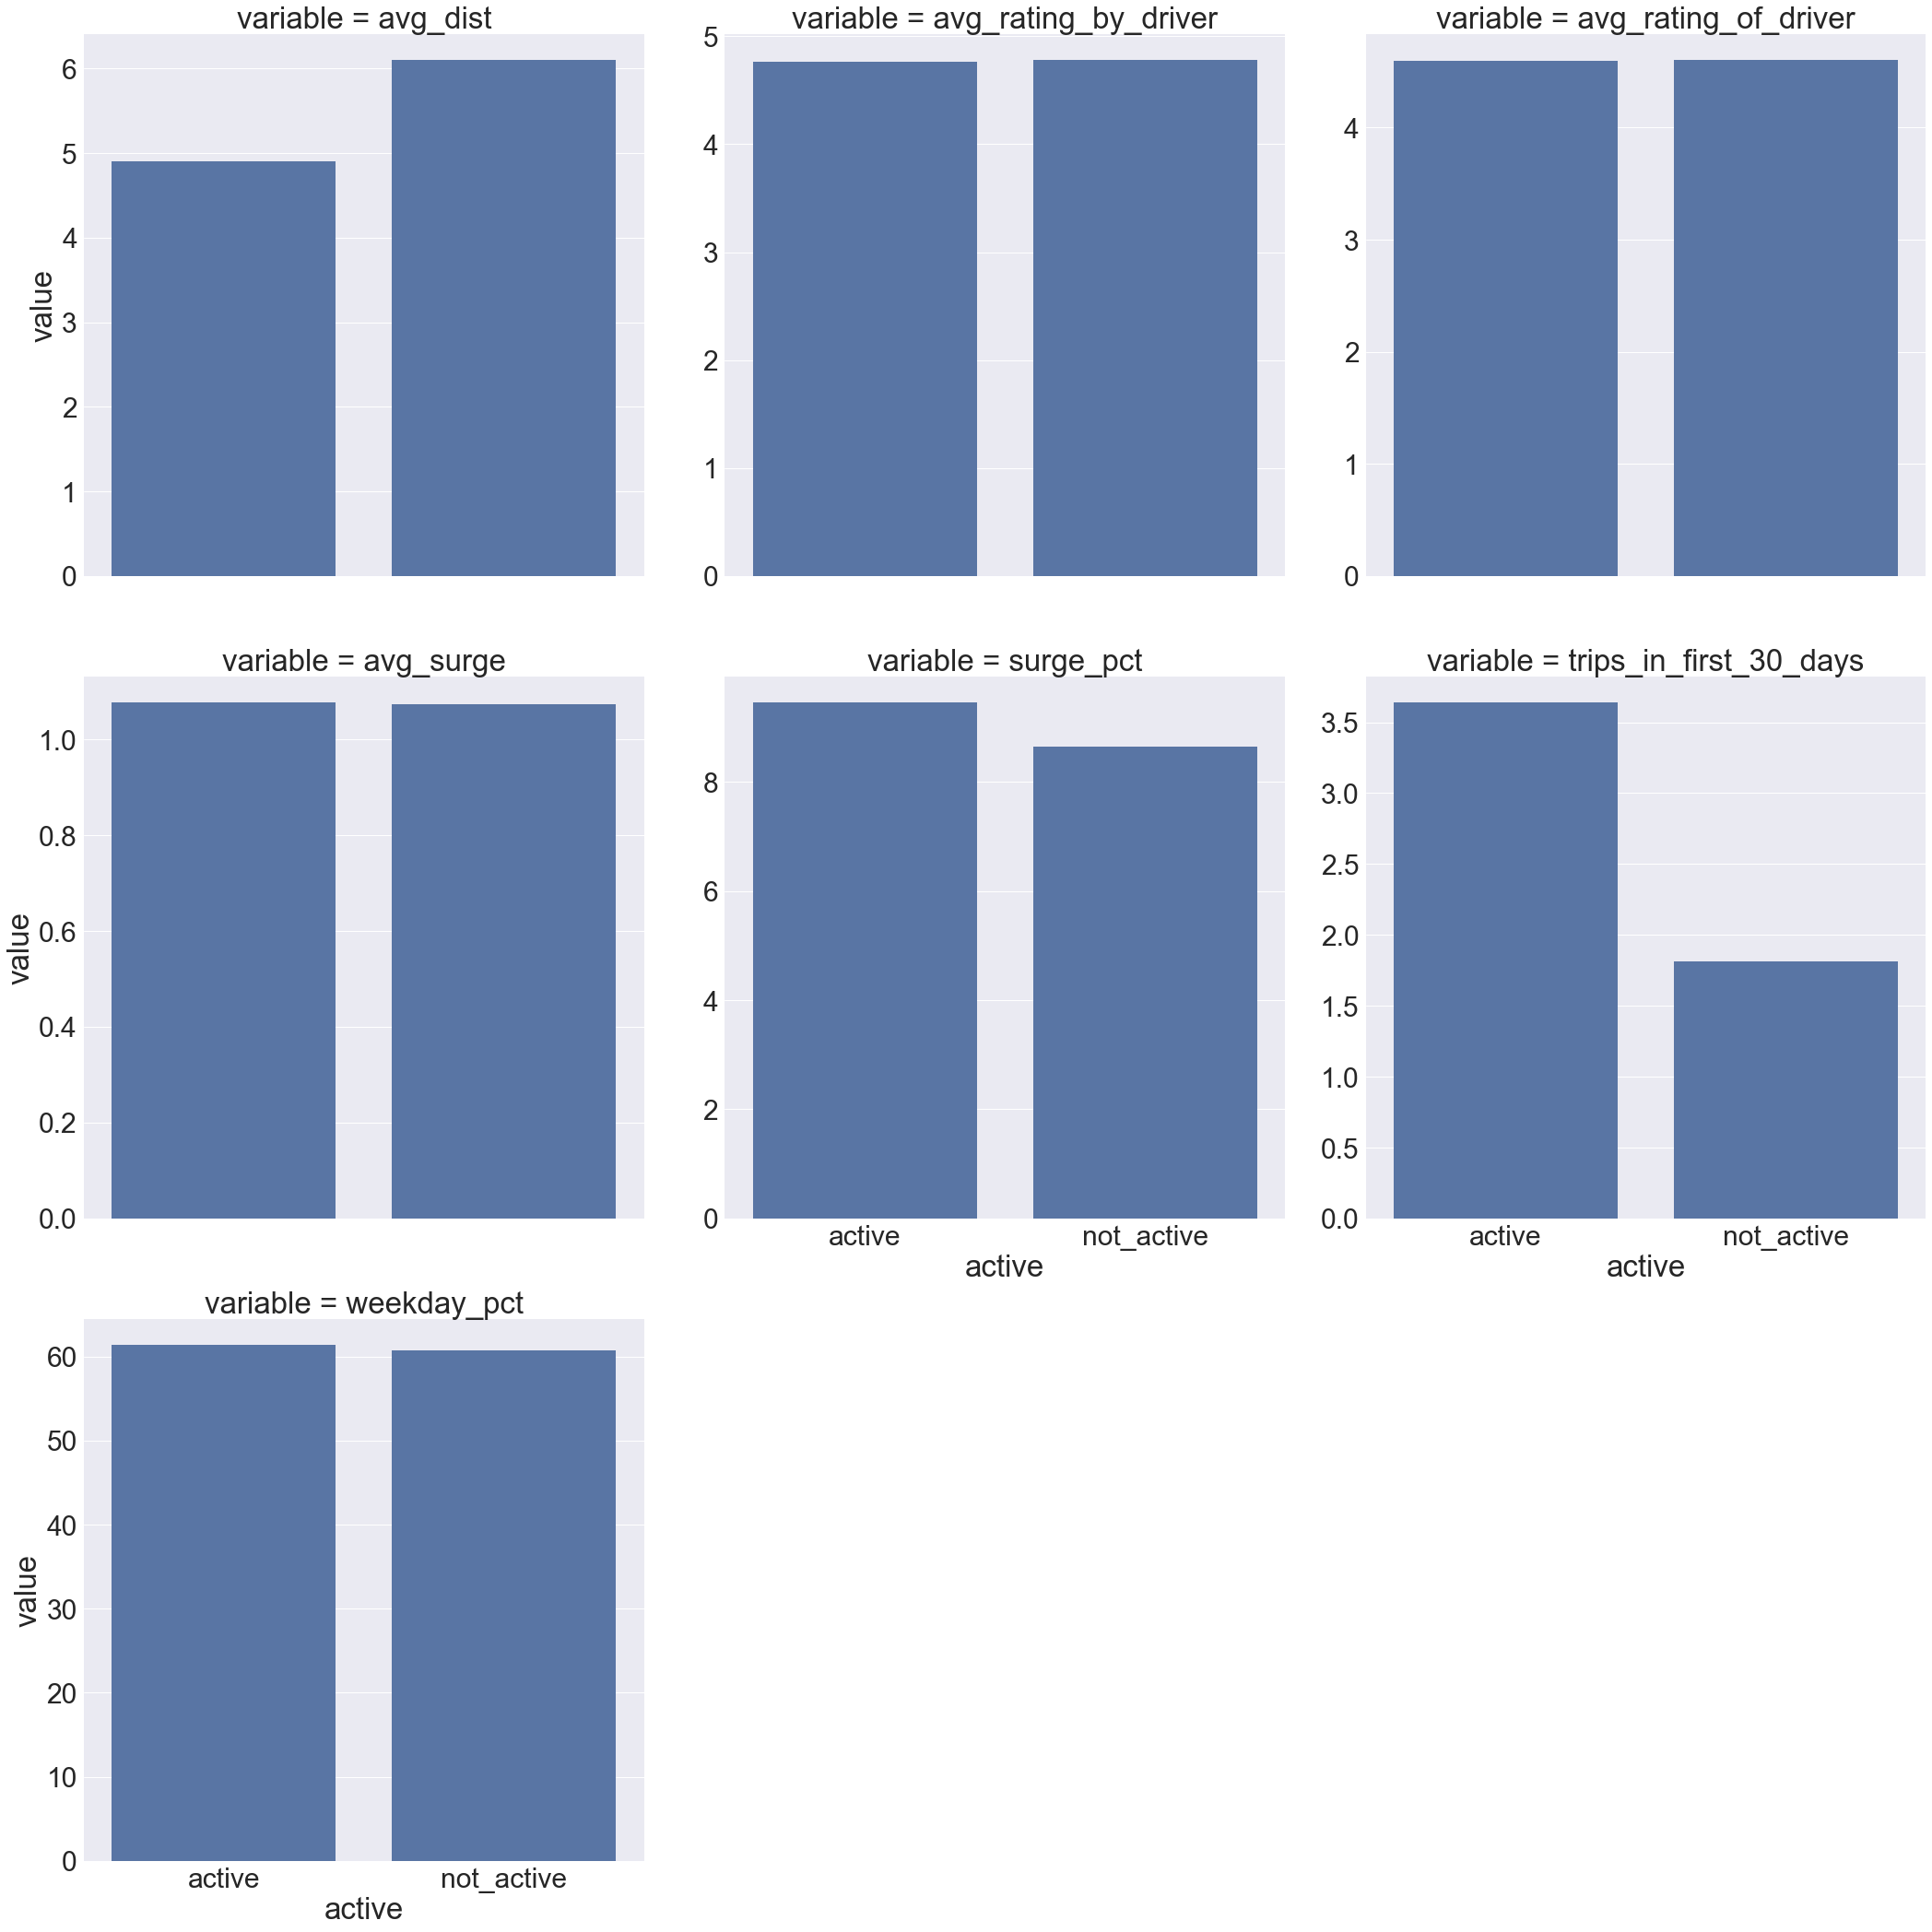

In [7]:

df_means = df[['avg_dist','avg_rating_by_driver','avg_rating_of_driver',
              'avg_surge','surge_pct','trips_in_first_30_days','weekday_pct','active']].groupby(['active']).mean()

df_means.reset_index(inplace=True)
df_means_long = pd.melt(df_means, id_vars=['active'])
sns.set(font_scale=3)
g = sns.FacetGrid(df_means_long, col="variable", sharey=False, size = 10, aspect = 1, col_wrap=3)
g = (g.map(sns.barplot, 'active','value'))
plt.show()

#### These bar plots suggest that average distance travelled might be an important determinant of which users are retained. It also makes sense that retained users used the services to a larger extent in the first 30 days.  User activity in the first 30 days and average distance travelled might be a good indicator of who is likely to remain a customer.  Next, I look at how these variables are correlated.

/Users/taniajogesh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


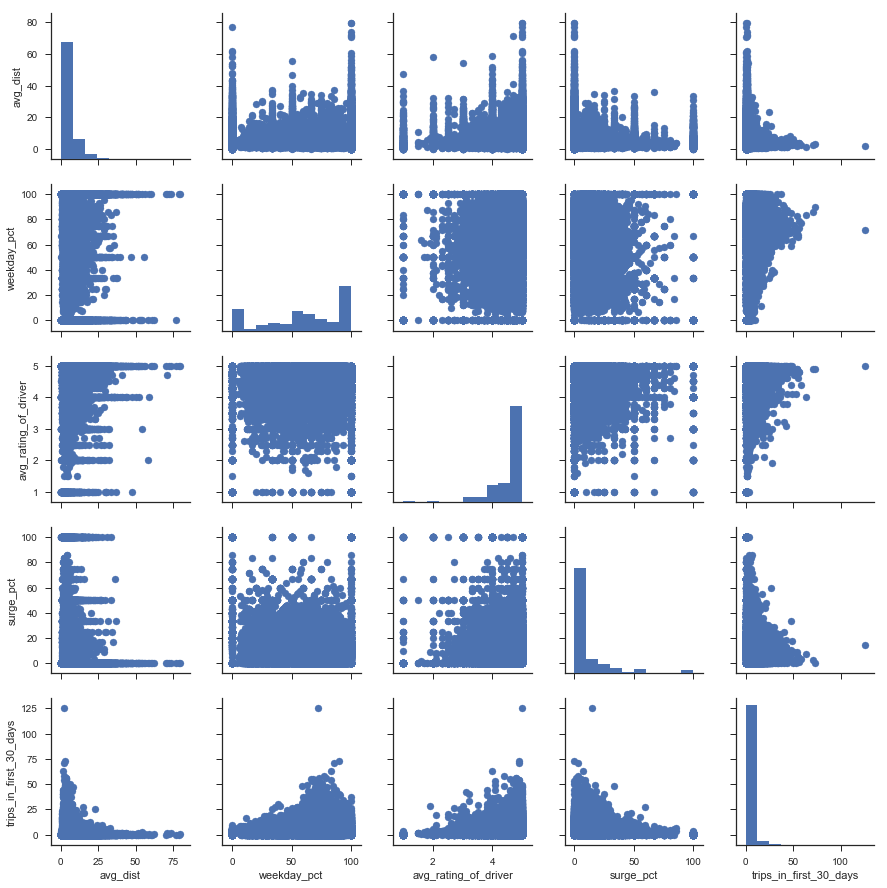

In [8]:
data = df[['avg_dist','weekday_pct','avg_rating_of_driver',
             'surge_pct','trips_in_first_30_days']]
data.dropna(inplace=True)
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.PairGrid(data)
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
plt.show()

#### Long distance riders are positively associted with better driver and passenger ratings and negatively associated with surge. This makes logical sense. Long communter potentially build a better report with their drivers leading to better ratings. Long communters are also less likely to ride in general and thus face fewer surge prices.  It is interesting that high ridership in the first 30 days is associated with better driver and commuter ratings. However, it is unclear where to attribute causation in this case. Better drivers could be the cause of more rides or taking more rides could incentivise riders to leave better reviews. Next, I look at the three catergorical variables in these data. 

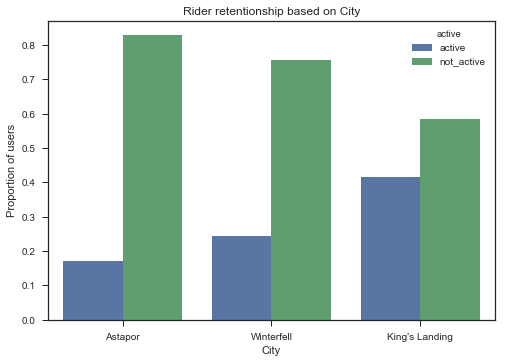

In [9]:
city= pd.crosstab(index=df["city"],  # Make a crosstab
                              columns=df["active"]).apply(lambda r: r/r.sum(), axis=1)
city.reset_index(inplace=True)
city_long = pd.melt(city, id_vars=['city']).sort_values('value')
ax = sns.barplot(x="city", y="value", hue="active", data=city_long)
plt.xlabel("City")
plt.ylabel("Proportion of users")
plt.title("Rider retentionship based on City") 
plt.show()

#### Kings Landing has a higher proportion of active rides while Astapor has the lowest proportion

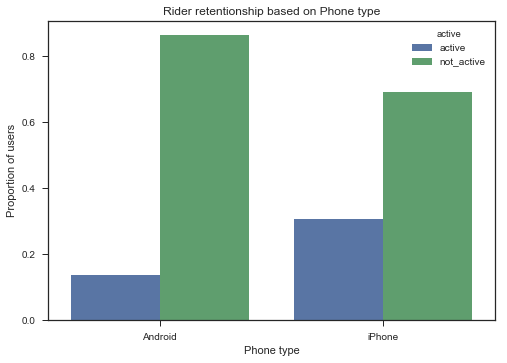

In [10]:
phone= pd.crosstab(index=df["phone"],  # Make a crosstab
                              columns=df["active"]).apply(lambda r: r/r.sum(), axis=1)
phone.reset_index(inplace=True)
phone_long = pd.melt(phone, id_vars=['phone']).sort_values('value')
ax = sns.barplot(x="phone", y="value", hue="active", data=phone_long)
plt.xlabel("Phone type")
plt.ylabel("Proportion of users")
plt.title("Rider retentionship based on Phone type") 
plt.show()

#### a larger proportion of iPhone users are active riders

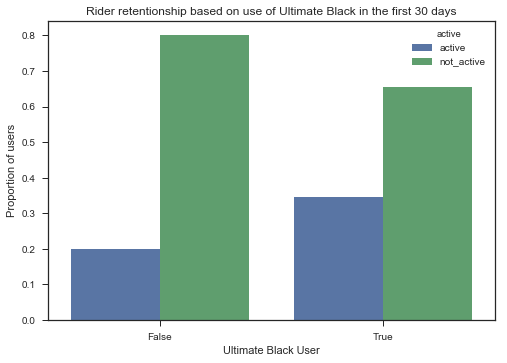

In [11]:
ultimate_black_user= pd.crosstab(index=df["ultimate_black_user"],  # Make a crosstab
                              columns=df["active"]).apply(lambda r: r/r.sum(), axis=1)
ultimate_black_user.reset_index(inplace=True)
ultimate_black_user_long = pd.melt(ultimate_black_user, id_vars=['ultimate_black_user']).sort_values('value')
ax = sns.barplot(x="ultimate_black_user", y="value", hue="active", data=ultimate_black_user_long)
plt.xlabel("Ultimate Black User")
plt.ylabel("Proportion of users")
plt.title("Rider retentionship based on use of Ultimate Black in the first 30 days") 
plt.show()

#### Finally, ultimate black users also tend to have higher ridership

## 2.) Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
activity_period           50000 non-null int64
active                    50000 non-null object
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(3)
memory usage: 5.0+ MB


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

#### feature engineering

In [14]:
cols_to_drop=['activity_period','signup_date','last_trip_date']
features=df.copy()
features.drop(cols_to_drop, axis =1, inplace=True)
features.avg_rating_by_driver.fillna(features.avg_rating_by_driver.mean(), inplace=True)
features.avg_rating_of_driver.fillna(features.avg_rating_of_driver.mean(), inplace=True)
features.phone.fillna("unknown", inplace=True)

In [15]:
label_encoder = LabelEncoder()
features.active = label_encoder.fit_transform(features['active'])
features.city = label_encoder.fit_transform(features['city'])
features.phone = label_encoder.fit_transform(features['phone'])
features.ultimate_black_user = label_encoder.fit_transform(features['ultimate_black_user'])

In [16]:
X= features.drop('active', axis =1).values
Y = features['active'].values

#### Random Forest Classifier  

In [17]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.30)
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit(xtrain, ytrain)
training_accuracy = forest.score(xtrain, ytrain)
test_accuracy = forest.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.998000
Accuracy on test data:     0.768467


ROC AUC: 0.79


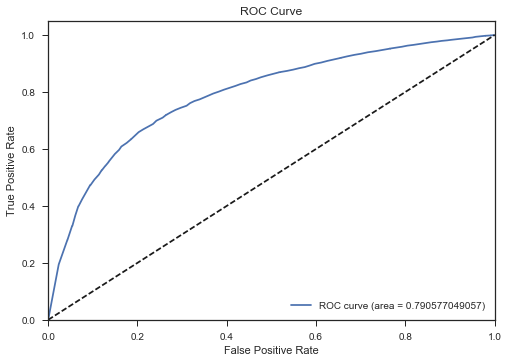

In [18]:
# Calculate the AUC
fpr, tpr, thresholds = roc_curve(ytest, forest.predict_proba(xtest)[:,1])
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### The classification accurancy and ROC curve suggest that the Random Forest classifier performs well but is likely overfitting the data. I chose to test the Random Forest Classifer because it is a great out-of-the-box algorithm that runs fast, has very little hyperparameter optimization with high accuracy for many data types and provides feature importance which can give us a good idea of where to focus our efforts to solve the problem.  It would be worth testing and optimizing other classifiers like gradient boosting, Bayes classifier and Support Vector Machines to impove the prediction accuracy. 

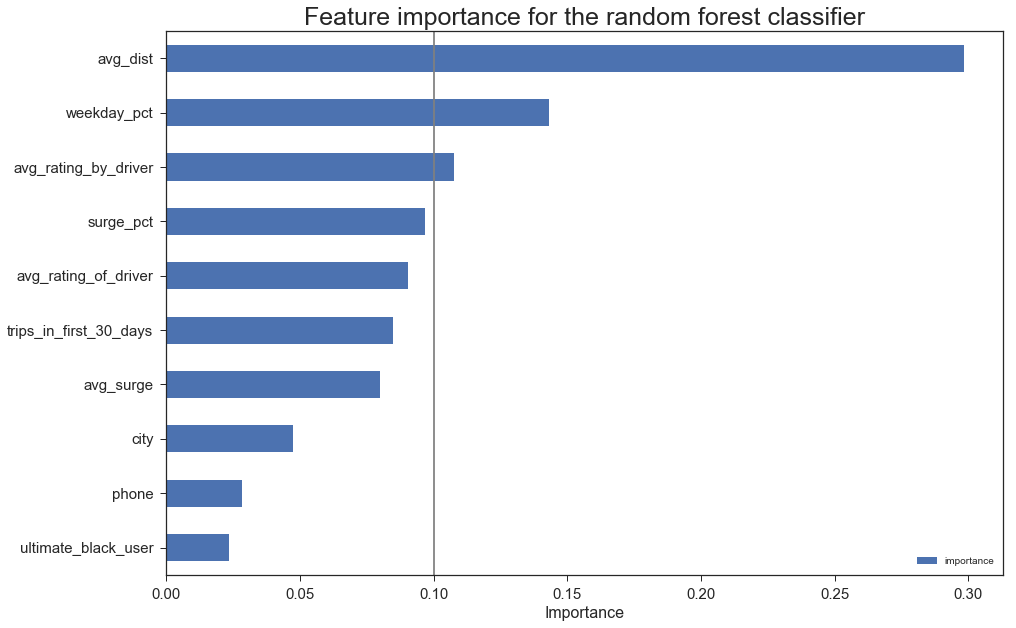

In [19]:
importances = forest.feature_importances_
feature_list = list(features.columns) 
feature_list.remove('active')
feature_importance = pd.DataFrame(zip(feature_list, importances), columns = ('feature','importance'))
feature_importance.set_index('feature', inplace=True)
feature_importance.sort_values('importance').plot(kind='barh', figsize=(15, 10))
plt.axvline(0.1, color="gray")
plt.title('Feature importance for the random forest classifier', fontsize = 25)
plt.xlabel('Importance', fontsize = 16)
plt.ylabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()## Missing data

#### Indeed, the average distance travelled by the rider minght be a really important predictor of rider retention. 

## 3.) Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

#### I would recommed two ideas. 1.) incentivise long distance riders, who likely pay more and might have cheaper alternatives. 2.) Weekday usage is on average slightly higher for active users and weekday useage is a pretty is an important feature in the classifictaion model. Weekday use is likely associated with a work commute so I would recommend that the company find ways to incentivise riders to use the service for their daily commute